# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_STATE = 42

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
display(df.head())
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Названия признаков

Приведем названия столбцов к нижнему регистру читаемому виду

In [5]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1", regex=True).str.lower().str.replace(' ', '_').str[1:]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Пропуски

Удалим неинформативные признаки datecrawled,datecreated,lastseen,numberofpictures которые не должны влиять на цену автомобиля

In [6]:
df.drop(columns=['date_crawled','date_created','last_seen','number_of_pictures'], inplace=True)

Проверим количество пропусков по признакам

In [7]:
df.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
postal_code               0
dtype: int64

**Рассмотрим признак типа автомобиля 'vehicle_type'**

In [8]:
display(df['vehicle_type'].unique())
display('Доля пропусков в vehicle_type: {:.2%}'.format(df['vehicle_type'].isna().mean()))

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

'Доля пропусков в vehicle_type: 10.58%'

Так как доля пропусков велика, удалить записи с пропусками недопустимо. Заполним пропуски значением other 

In [9]:
df.vehicle_type.fillna('other', inplace=True)
df['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: vehicle_type, dtype: int64

**Рассмотрим признак типа коробки передач 'gearbox'**

In [10]:
display(df['gearbox'].unique())
display('Доля пропусков в gearbox: {:.2%}'.format(df['gearbox'].isna().mean()))

array(['manual', 'auto', nan], dtype=object)

'Доля пропусков в gearbox: 5.60%'

Заполним пропуски значением 'undef'

In [11]:
df.gearbox.fillna('undef', inplace=True)

**Рассмотрим признак модели авто 'model'**

In [12]:
display(df['model'].unique())
display('Доля пропусков в model: {:.2%}'.format(df['model'].isna().mean()))

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

'Доля пропусков в model: 5.56%'

Заполним пропуски значением other

In [13]:
df.model.fillna('other', inplace=True)

**Рассмотрим признак типа топлива 'fuel_type'**

In [14]:
display(df['fuel_type'].unique())
display('Доля пропусков в fuel_type: {:.2%}'.format(df['fuel_type'].isna().mean()))

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

'Доля пропусков в fuel_type: 9.28%'

Заполним пропуски значением other. Значения gasoline заменим на petrol так как это одно и то же

In [15]:
df.fuel_type.fillna('other', inplace=True)
df['fuel_type'] = df['fuel_type'].replace(['gasoline'],'petrol')
display(df['fuel_type'].unique())

array(['petrol', 'other', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

**Рассмотрим признак ремонтировалось ли авто 'repaired'**

In [16]:
display(df['repaired'].unique())
display('Доля пропусков в repaired: {:.2%}'.format(df['repaired'].isna().mean()))

array([nan, 'yes', 'no'], dtype=object)

'Доля пропусков в repaired: 20.08%'

Так как доля пропусков велика, удалить записи с пропусками недопустимо. Заполним пропуски значением undef 

In [17]:
df.repaired.fillna('undef', inplace=True)

In [18]:
df.isna().sum()

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
postal_code           0
dtype: int64

### Аномалии

Рассмотрим наличие аномалий

,price,registration_year,power,kilometer,registration_month,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


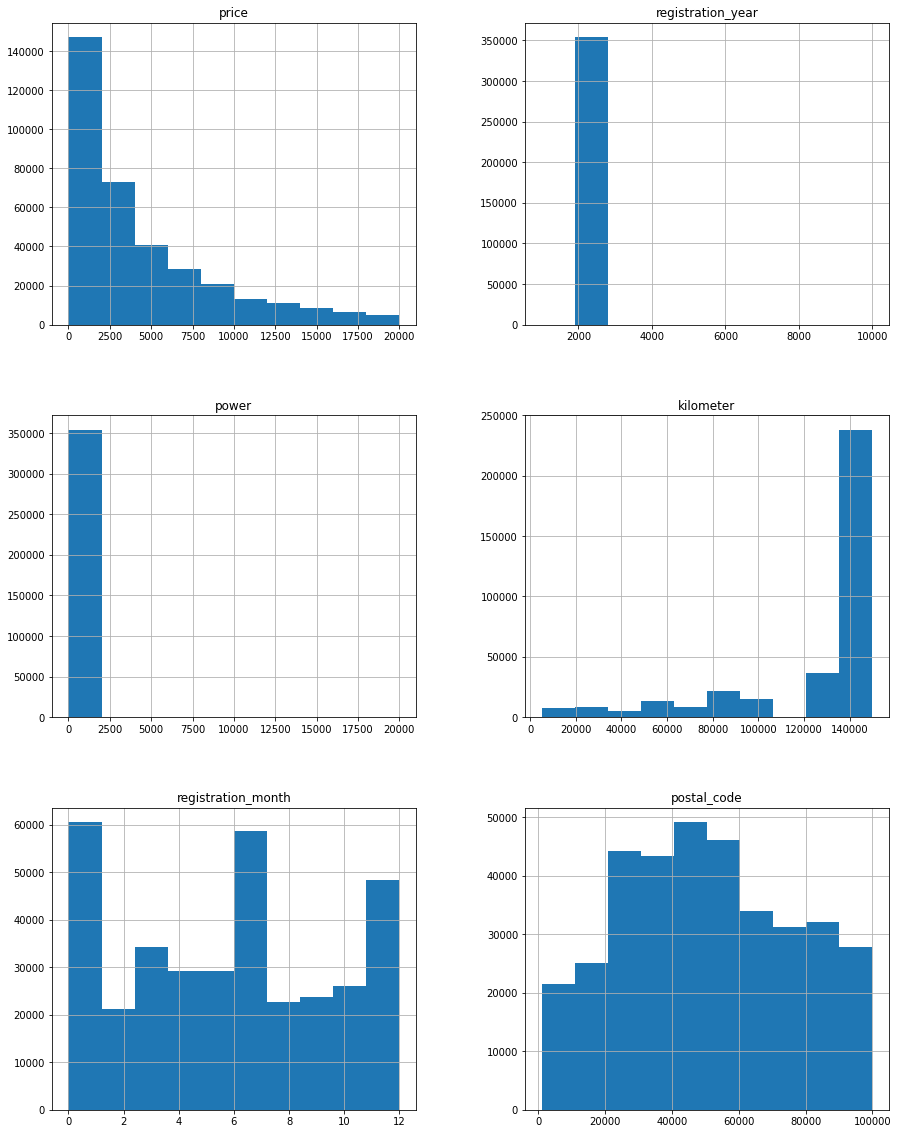

In [19]:
display(df.describe())
df.hist(figsize=(15, 20))
plt.show()

**Рассмотрим признак цены авто 'price'**

In [20]:
display('Доля нулей в price: {:.2%}'.format((df['price']==0).mean()))

'Доля нулей в price: 3.04%'

price целевой признак, заполнение медианным значением не даст улучшений данных при обучении. Так как доля нулей в price невелика, удалим записи с нулевым значением.

In [21]:
df = df.loc[df['price'] > 0]

**Рассмотрим признак года регистрации авто 'registration_year'**

В условии указано что данные представлены на 2016 год, ограничим верхнюю границу года регистрации 2016. Нижнюю границу установим на 1885 год(год выпуска первого авто Benz Patent-Motorwagen)

In [22]:
df = df.loc[(df['registration_year'] <= 2016) & (df['registration_year'] >= 1885)]

**Рассмотрим признак мощности авто 'power'**

In [23]:
display('Доля нулей в power: {:.2%}'.format((df['power']==0).mean()))

'Доля нулей в power: 9.97%'

Ограничим мощность авто от 50л.с до 2000л.с(Максимальная возможная мощность), так же авто не может быть с нулевой мощностью, заменим нули на медианное значение.

In [24]:
df = df.loc[(df['power'] <= 2000) & (df['power'] >= 50)]

In [25]:
df['power'] = df['power'].replace(0, df['power'].median())

**Рассмотрим признак месяца регистрации авто 'registration_month'**

In [26]:
df['registration_month'].value_counts()

3     30016
6     27146
4     25362
5     25230
7     23447
10    22619
12    20902
11    20760
9     20664
1     19811
8     19451
2     18552
0     17329
Name: registration_month, dtype: int64

Нулевые значения скорее всего соответствуют январю, заменим значения на 1 

In [27]:
df['registration_month'] = df['registration_month'].replace(0, 1)

,price,registration_year,power,kilometer,registration_month,postal_code
count,291289.000000,291289.000000,291289.000000,291289.000000,291289.000000,291289.000000
mean,4909.321931,2002.967898,122.991788,128488.871876,6.062203,51320.842376
std,4621.423073,6.325263,62.879999,36575.245726,3.486906,25778.993698
min,1.000000,1910.000000,50.000000,5000.000000,1.000000,1067.000000
25%,1399.000000,1999.000000,80.000000,125000.000000,3.000000,30982.000000
50%,3250.000000,2003.000000,115.000000,150000.000000,6.000000,50354.000000
75%,7000.000000,2007.000000,150.000000,150000.000000,9.000000,72147.000000
max,20000.000000,2016.000000,2000.000000,150000.000000,12.000000,99998.000000


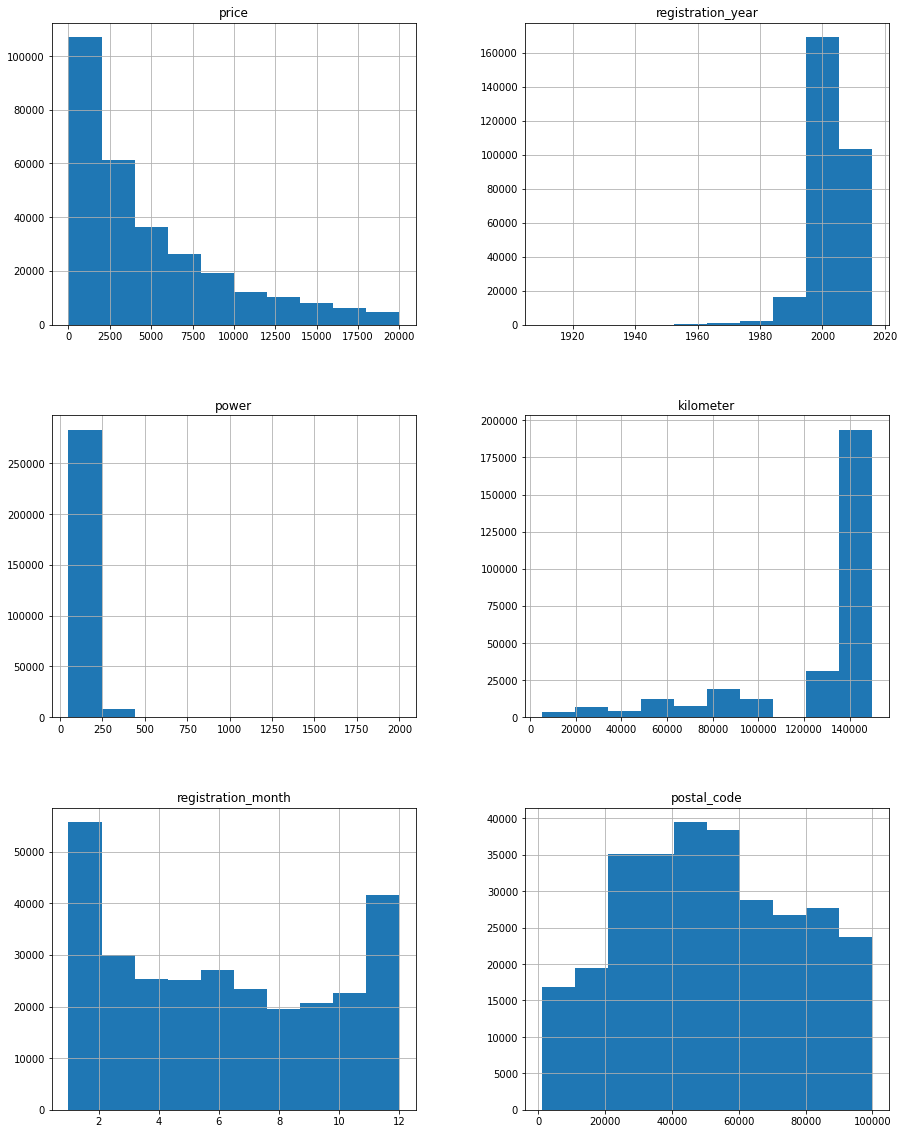

In [28]:
display(df.describe())
df.hist(figsize=(15, 20))
plt.show()

### Дубликаты

Проверим данные на дубликаты

In [29]:
df.duplicated().sum()

18606

Удалим их

In [30]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272683 entries, 0 to 272682
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               272683 non-null  int64 
 1   vehicle_type        272683 non-null  object
 2   registration_year   272683 non-null  int64 
 3   gearbox             272683 non-null  object
 4   power               272683 non-null  int64 
 5   model               272683 non-null  object
 6   kilometer           272683 non-null  int64 
 7   registration_month  272683 non-null  int64 
 8   fuel_type           272683 non-null  object
 9   brand               272683 non-null  object
 10  repaired            272683 non-null  object
 11  postal_code         272683 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 25.0+ MB


### Вывод

Выполнена предобработка данных:  
-Изменены названия признаков  
-Заполнены пропуски в признаках vehicle_type,gearbox,model,fuel_type,repaired  
-Удалены бесполезные признаки date_crawled,date_created,last_seen,number_of_pictures  
-Удалены дубликаты   
-Ограничены аномальные значения  
Процент Сохраненных данных 77%

## Обучение моделей

### Подготовка данных

Выполним разделение на выборки и выделим целевой признак

In [32]:
df_train_base, df_test = train_test_split(df, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_train_base, test_size=0.25, random_state=12345)
features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']
features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']
features_valid = df_valid.drop(['price'], axis=1)
target_valid = df_valid['price']

Выполним кодирование категориальных признаков 

In [33]:
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()
oe = OrdinalEncoder(handle_unknown='ignore')
cat_features = ['vehicle_type','registration_year', 'gearbox', 'power', 
            'model', 'kilometer','fuel_type',
            'brand', 'repaired']
features_train_oe[cat_features] = oe.fit_transform(features_train_oe[cat_features])
features_test_oe[cat_features] = oe.transform(features_test_oe[cat_features])

In [34]:
features_train_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
132898,4.0,54.0,1.0,25.0,78.0,12.0,5,5.0,22.0,0.0,10367
138031,4.0,63.0,1.0,127.0,43.0,12.0,3,5.0,36.0,0.0,32425
38985,7.0,69.0,1.0,90.0,139.0,2.0,12,5.0,30.0,0.0,30982
110837,3.0,56.0,1.0,65.0,116.0,12.0,8,5.0,38.0,1.0,95339
238677,1.0,62.0,1.0,113.0,165.0,12.0,9,5.0,1.0,0.0,56075


Выполним кодирование категориальных признаков способом OHE

In [35]:
df_ohe = df.copy()
df_ohe = pd.get_dummies(df, drop_first=True)
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop('price', axis=1)

features_base_ohe, features_test_ohe, target_base_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.2, random_state=RANDOM_STATE)

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_base_ohe, target_base_ohe, test_size=0.25, random_state=RANDOM_STATE)

Отмасштабируем признаки

In [36]:
scaler_oe = StandardScaler()
scaler_oe.fit(features_train_oe)
features_train_oe = scaler_oe.transform(features_train_oe)
features_test_oe = scaler_oe.transform(features_test_oe)

numeric = ['power', 'kilometer']

scaler_ohe = StandardScaler()
scaler_ohe.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler_ohe.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler_ohe.transform(features_test_ohe[numeric])
features_valid_ohe[numeric] = scaler_ohe.transform(features_valid_ohe[numeric])

### LinearRegression

In [37]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe)

predictions_train_ohe = model.predict(features_train_ohe)
rmse = mean_squared_error(target_train_ohe, predictions_train_ohe)**0.5
print(rmse)

2702.655864453216
CPU times: user 18.1 s, sys: 14.1 s, total: 32.3 s
Wall time: 32.3 s


### Catboost

In [38]:
%%time
catboost = CatBoostRegressor(loss_function='RMSE')
parameters_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(parameters_cat,
            Pool(features_train, target_train, cat_features=["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"]),
            cv=3,
            verbose=10,
            plot=False)

0:	learn: 6171.2387986	test: 6197.3014713	best: 6197.3014713 (0)	total: 252ms	remaining: 4m 11s
1:	learn: 5680.6935471	test: 5706.2229337	best: 5706.2229337 (1)	total: 432ms	remaining: 3m 35s
2:	learn: 5246.7179613	test: 5271.9491147	best: 5271.9491147 (2)	total: 653ms	remaining: 3m 36s
3:	learn: 4855.5826586	test: 4880.4841027	best: 4880.4841027 (3)	total: 846ms	remaining: 3m 30s
4:	learn: 4516.8778990	test: 4541.3895520	best: 4541.3895520 (4)	total: 1.02s	remaining: 3m 23s
5:	learn: 4212.6001360	test: 4235.8530366	best: 4235.8530366 (5)	total: 1.19s	remaining: 3m 17s
6:	learn: 3947.4555832	test: 3970.9145516	best: 3970.9145516 (6)	total: 1.31s	remaining: 3m 5s
7:	learn: 3710.6600184	test: 3735.8934567	best: 3735.8934567 (7)	total: 1.47s	remaining: 3m 2s
8:	learn: 3497.4393093	test: 3522.7740695	best: 3522.7740695 (8)	total: 1.61s	remaining: 2m 57s
9:	learn: 3312.9554929	test: 3338.0355316	best: 3338.0355316 (9)	total: 1.75s	remaining: 2m 52s
10:	learn: 3150.7508133	test: 3176.0636064

In [39]:
catboost_grid["params"]

{'depth': 10, 'learning_rate': 0.1}

In [51]:
%%time
 final_cat = CatBoostRegressor(catboost_grid["params"]["depth"], 
                              catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(features_train,target_train,
                   cat_features=["vehicle_type","gearbox","model","fuel_type","brand","repaired"]))

0:	learn: 4324.8615605	total: 81.4ms	remaining: 733ms
9:	learn: 2791.4102951	total: 726ms	remaining: 0us
CPU times: user 1.05 s, sys: 12 ms, total: 1.06 s
Wall time: 1.68 s


### LightGBM

In [41]:
%%time
lgb_train = lgb.Dataset(features_train_ohe, target_train_ohe)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train],
                verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 163609, number of used features: 285
[LightGBM] [Info] Start training from score 4869.993130
[100]	training's l2: 2.74706e+06
[200]	training's l2: 2.52248e+06
[300]	training's l2: 2.39147e+06
[400]	training's l2: 2.30042e+06
[500]	training's l2: 2.22679e+06
[600]	training's l2: 2.15736e+06
[700]	training's l2: 2.10014e+06
[800]	training's l2: 2.05165e+06
[900]	training's l2: 2.00343e+06
[1000]	training's l2: 1.95214e+06
CPU times: user 9min 15s, sys: 10.3 s, total: 9min 25s
Wall

Найдем RMSE каждой модели на валидационной выборке

In [42]:
%%time
predict_cb = final_cat.predict(features_valid)

CPU times: user 70.2 ms, sys: 30 µs, total: 70.3 ms
Wall time: 130 ms


In [43]:
display("CatBoost:",mean_squared_error(target_valid,predict_cb,squared=False))

'CatBoost:'

2765.8619902808414

In [44]:
%%time
predict_lgbm = light.predict(features_valid_ohe)

CPU times: user 6.3 s, sys: 191 ms, total: 6.49 s
Wall time: 6.46 s


In [45]:
display("LightGBM:",mean_squared_error(target_valid_ohe, predict_lgbm,squared=False))

'LightGBM:'

1572.3447053261932

In [46]:
%%time
predict_lr = model.predict(features_valid_ohe)

CPU times: user 80.2 ms, sys: 36.2 ms, total: 116 ms
Wall time: 78.6 ms


In [47]:
display("LinearRegression:",mean_squared_error(target_valid_ohe, predict_lr,squared=False))

'LinearRegression:'

2714.5420189657198

## Анализ моделей

Определим важность признаков в обучении catboost

Text(0.5, 1.0, 'Feature Importance')

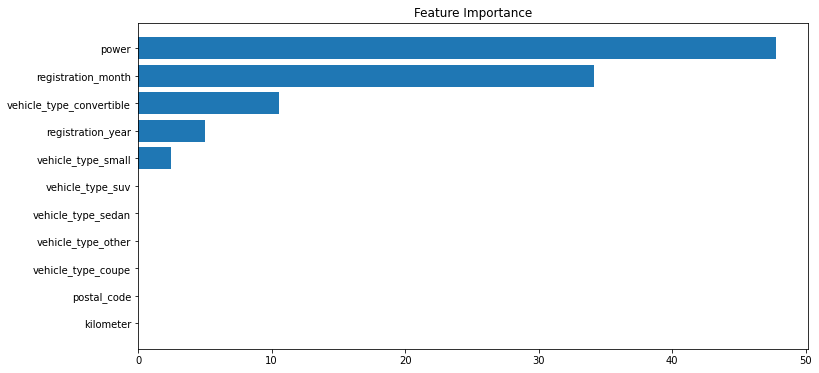

In [48]:
feature_importance = final_cat.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train_ohe.columns)[sorted_idx])
plt.title('Feature Importance')

Определим важность признаков в обучении LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

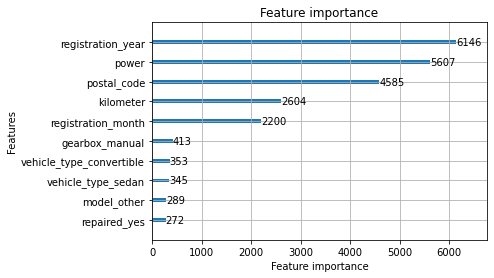

In [49]:
lgb.plot_importance(light,max_num_features = 10)

Показатель RMSE:  
LinearRegression 2714  
LightGBM         1572  
CatBoost         2765  

Время обучения:  
LinearRegression 334ms  
LightGBM         9min 25s 
CatBoost         1.19 s 

По времени предсказания:  
LinearRegression 116ms  
LightGBM         6.5s  
CatBoost         70.3 ms  

Несмотря на быстрое время обучения модель линейной регресси имеет большое значение RMSE, наиболее подходящая модель - LightGBM, так как по всем показателям оно лучше чем CatBoost. Так же у LightGBM самым важным признаком оказалась год регистрации автомобиля, что характерно для оценки стоимости авто. 


Проверим выбранную модель на тестовой выборке

In [52]:
predict_lgbm = light.predict(features_test_ohe)

display("LightGBMtest RMSE:", mean_squared_error(target_test_ohe, predict_lgbm,squared=False))

'LightGBMtest RMSE:'

1593.3508904481644